In [ ]:
def emulate_bot_portfolio_generation(
    strategy_profile='moderate', 
    allow_short=True,
    custom_params=None
):
    """
    Эмулирует работу телеграм-бота при генерации портфеля.
    
    Args:
        strategy_profile: Профиль риска ('conservative', 'moderate', 'aggressive')
        allow_short: Разрешены ли короткие позиции
        custom_params: Словарь с кастомными параметрами для переопределения
        
    Returns:
        Tuple[Dict, Dict, Dict]: (weights, metrics, full_report)
    """
    from pys.porfolio_optimization.executor import PipelineExecutor
    from pys.data_collection.kbd import run_pipeline_kbd_parser
    from pys.data_collection.private_info import BASE_PATH
    import pandas as pd
    from datetime import datetime
    import numpy as np
    from params import COMMON_PARAMS, PORTFOLIO_PARAMS, KBD_DATA_PATH, KBD_PARAMS, SELECT_PARAMS_BY_PROFILE, SIGNAL_PARAMS, TICKERS, OPTIMIZATION_PARAMS
    
    # --- 1. Подготовка параметров ---
    if custom_params is None:
        custom_params = {}
    
    base_params = {
        "start_date": COMMON_PARAMS['start_date'],
        "end_date": COMMON_PARAMS['end_date'],
        "train_period": COMMON_PARAMS['train_period'],
        "test_period": COMMON_PARAMS['test_period'],
        "risk_free_rate": COMMON_PARAMS['risk_free_rate'],
        "min_rf_allocation": None,
        "max_rf_allocation": None,
        "max_weight": None,
        "signal_params": SIGNAL_PARAMS.copy(),
        "min_assets": 5,
        "max_assets": 15
    }
    
    # --- 2. Настройка параметров портфеля в соответствии с профилем ---
    portfolio_base_params = PORTFOLIO_PARAMS.get(strategy_profile, PORTFOLIO_PARAMS['moderate']).copy()
    
    base_params["min_rf_allocation"] = portfolio_base_params['min_rf_allocation']
    base_params["max_rf_allocation"] = portfolio_base_params['max_rf_allocation']
    base_params["max_weight"] = portfolio_base_params['max_weight']
    
    for key, value in custom_params.items():
        if key == "signal_params" and isinstance(value, dict):
            for signal_key, signal_val in value.items():
                base_params["signal_params"][signal_key] = signal_val
        else:
            base_params[key] = value
    
    print("\n=== Применяемые параметры ===")
    print(f"risk_free_rate: {base_params['risk_free_rate']}")
    print(f"min_rf_allocation: {base_params['min_rf_allocation']}")
    print(f"max_rf_allocation: {base_params['max_rf_allocation']}")
    print(f"max_weight: {base_params['max_weight']}")
    print(f"min_assets: {base_params['min_assets']}")
    print(f"max_assets: {base_params['max_assets']}")
    print(f"allow_short: {allow_short}")
    print("============================\n")
    
    executor_init_params = {
        'base_path': BASE_PATH,
        'name': f"{strategy_profile}_test_{datetime.now().strftime('%Y%m%d_%H%M')}",
        'strategy_profile': strategy_profile,
        'min_position_weight': portfolio_base_params['min_position_weight'],
        'min_rf_allocation': base_params['min_rf_allocation'],
        'max_rf_allocation': base_params['max_rf_allocation'],
        'risk_free_rate': base_params['risk_free_rate'],
        'max_weight': base_params['max_weight'],
        'min_assets': base_params['min_assets'],
        'max_assets': base_params['max_assets']
    }
    
    print(f"Инициализация PipelineExecutor с параметрами профиля {strategy_profile}")
    executor = PipelineExecutor(**executor_init_params)
    
    # --- 4. Загрузка/обработка данных КБД ---
    print("Загрузка данных КБД...")
    try:
        kbd_path = KBD_DATA_PATH
        if not kbd_path.exists():
            print("КБД файл не найден. Запуск пайплайна KBD...")
            run_pipeline_kbd_parser(
                base_path=BASE_PATH,
                start_date=base_params['start_date'],
                end_date=base_params['end_date'],
                update_data=True
            )
        
        kbd_data = pd.read_csv(kbd_path)
        print(f"Загружено {len(kbd_data)} записей КБД")
    except Exception as e:
        print(f"Ошибка при загрузке КБД данных: {e}")
        kbd_data = pd.DataFrame()
    
    # --- 5. Обработка облигаций ---
    bond_processing_params = {
        'start_date': base_params['start_date'],
        'end_date': base_params['end_date'],
        'min_bonds': KBD_PARAMS['min_bonds'],
        'max_threshold': KBD_PARAMS['max_threshold'],
        'strategy_profile': strategy_profile,
        'kbd_yield_adjustment': KBD_PARAMS['kbd_yield_adjustment'],
        'update_kbd_data': False,
        'excluded_issuers': ['ВТБ', 'Мечел'],
        'n_bonds': 5,  # По умолчанию 5 облигаций
        'kbd_data': kbd_data,
        'portfolio_stability': KBD_PARAMS['portfolio_stability'],
        'use_kbd_recommendations': True,
        'kbd_duration_flexibility': KBD_PARAMS['kbd_duration_flexibility'],
        'max_adjustment_iterations': KBD_PARAMS['max_adjustment_iterations'],
        'weighting_strategy': None,
        'override_params': None,
        'output_format': 'all'
    }
    
    print("Обработка облигаций...")
    bond_results = None
    try:
        bond_results = executor.process_bond_pipeline(**bond_processing_params)
        if bond_results:
            print("Обработка облигаций успешно завершена")
        else:
            print("Обработка облигаций не вернула результатов")
    except Exception as e:
        print(f"Ошибка при обработке облигаций: {e}")
    
    # --- 6. Формирование параметров для запуска основного пайплайна ---
    standard_portfolio_params = {
        'risk_free_rate': base_params['risk_free_rate'],
        'min_rf_allocation': base_params['min_rf_allocation'],
        'max_rf_allocation': base_params['max_rf_allocation'],
        'max_weight': base_params['max_weight'],
        'include_short_selling': False
    }
    
    short_portfolio_params = {
        'risk_free_rate': base_params['risk_free_rate'],
        'train_period': base_params['train_period'],
        'test_period': base_params['test_period'],
        'best_params_file': None,
        'verify_with_honest_backtest': False  # False для скорости
    }
    
    combined_portfolio_params = {
        'risk_free_rate': base_params['risk_free_rate'],
        'min_rf_allocation': base_params['min_rf_allocation'],
        'max_rf_allocation': base_params['max_rf_allocation'],
        'max_weight': base_params['max_weight'],
        'long_ratio': portfolio_base_params.get('long_ratio', 0.7),
        'include_short_selling': True
    }
    
    portfolio_controls = {
        'run_standard_portfolio': True,
        'run_short_portfolio': allow_short,
        'run_combined_portfolio': allow_short and strategy_profile in ['moderate', 'aggressive'],
        'override_risk_profile': False
    }
    
    optimization_params_modified = OPTIMIZATION_PARAMS.copy() if OPTIMIZATION_PARAMS else {}
    optimization_params_modified.update({
        'constraints': {
            'min_assets': base_params['min_assets'],
            'max_assets': base_params['max_assets']
        }
    })
    
    select_portfolio_params = SELECT_PARAMS_BY_PROFILE[strategy_profile].copy()
    
    # --- 7. Запуск основного пайплайна ---
    print(f"Запуск основного пайплайна для профиля {strategy_profile} (allow_short={allow_short})...")
    try:
        pipeline_results = executor.run_pipeline(
            tickers_list=TICKERS,
            bond_results=bond_results,
            strategy_profile=strategy_profile,
            signal_params=base_params['signal_params'],
            standard_portfolio_params=standard_portfolio_params,
            short_portfolio_params=short_portfolio_params,
            combined_portfolio_params=combined_portfolio_params,
            optimization_params=optimization_params_modified,
            portfolio_controls=portfolio_controls,
            select_portfolio_params=select_portfolio_params,
            report_params={
                'include_charts': True,
                'include_metrics': True,
                'include_weights': True,
                'report_format': 'md'
            },
            visualization_params={
                'plot_style': 'ggplot',
                'chart_size': (12, 8),
                'dpi': 300
            },
            min_assets=base_params['min_assets'],
            max_assets=base_params['max_assets']
        )
        
        print(f"Основной пайплайн завершен успешно! Ограничение на количество активов: {base_params['max_assets']}")
        
        # --- 8. Обработка результатов ---
        if not pipeline_results or 'best_portfolio' not in pipeline_results:
            print("Пайплайн не вернул данных о лучшем портфеле")
            return None, None, None
        
        best_portfolio_data = pipeline_results['best_portfolio']
        
        if not isinstance(best_portfolio_data, dict) or 'type' not in best_portfolio_data:
            print(f"Неверная структура данных лучшего портфеля: {best_portfolio_data}")
            return None, None, None
        
        portfolio_type = best_portfolio_data.get('type')
        portfolio_data = best_portfolio_data.get('portfolio', {})
        metrics_data = best_portfolio_data.get('metrics', {})
        
        if not isinstance(portfolio_data, dict) or 'weights' not in portfolio_data:
            print(f"Отсутствуют веса в данных портфеля типа {portfolio_type}")
            return None, None, None
        
        final_weights = portfolio_data['weights']
        final_metrics = metrics_data
        
        active_positions = sum(1 for ticker, weight in final_weights.items() 
                              if ticker != 'RISK_FREE' and abs(weight) > 0.01)
        print(f"Фактическое количество активных позиций в портфеле: {active_positions}")
        if active_positions > base_params['max_assets']:
            print(f"ВНИМАНИЕ: Количество активов ({active_positions}) превышает ограничение ({base_params['max_assets']})")
            print("Это может указывать на проблему в применении ограничений в PipelineExecutor.")
        
            if base_params['max_assets'] < active_positions:
                print("Применяем ограничение на количество активов вручную...")
                sorted_weights = sorted(
                    [(k, v) for k, v in final_weights.items() if k != 'RISK_FREE'],
                    key=lambda x: abs(x[1]),
                    reverse=True
                )
                
                top_assets = sorted_weights[:base_params['max_assets']]
                
                new_weights = {'RISK_FREE': final_weights.get('RISK_FREE', 0)}
                for ticker, weight in top_assets:
                    new_weights[ticker] = weight
                
                total_weight = sum(abs(w) for w in new_weights.values())
                if total_weight > 0:
                    new_weights = {k: v/total_weight for k, v in new_weights.items()}
                
                final_weights = new_weights
                print(f"Новое количество активов после ручного ограничения: {len(final_weights)-1}")
        
        report = {
            "weights": final_weights,
            "metrics": final_metrics,
            "images": {},
            "portfolio_type": portfolio_type,
            "generated_at": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        run_path = pipeline_results.get('run_dir', None)
        if run_path:
            print(f"Результаты сохранены в директории: {run_path}")
        
        python_weights = {}
        for k, v in final_weights.items():
            python_weights[k] = float(v) if isinstance(v, (np.float32, np.float64)) else v
        
        python_metrics = {}
        for k, v in final_metrics.items():
            python_metrics[k] = float(v) if isinstance(v, (np.float32, np.float64)) else v
        
        print(f"Тип выбранного портфеля: {portfolio_type}")
        print(f"Количество активов: {len(python_weights)}")
        print(f"Ключевые метрики: Доходность={python_metrics.get('expected_return', 0)*100:.2f}%, "
              f"Волатильность={python_metrics.get('expected_volatility', 0)*100:.2f}%, "
              f"Шарп={python_metrics.get('sharpe_ratio', 0):.2f}")
        
        return python_weights, python_metrics, report
        
    except Exception as e:
        print(f"Ошибка при выполнении основного пайплайна: {e}")
        return None, None, None


2025-04-29 17:09:07 - PipelineExecutor - INFO - Создана структура директорий для запуска run_20250429_170907_aggressive_test_20250429_1709
2025-04-29 17:09:07 - PipelineExecutor - INFO - Запуск полного цикла обработки облигаций
2025-04-29 17:09:07 - PipelineExecutor - INFO - Создана структура директорий для облигаций в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds
2025-04-29 17:09:07 - MOEXBondHistoricalParser - INFO - MOEX Bond Parser initialized
2025-04-29 17:09:07 - PipelineExecutor - INFO - Датасет облигаций скопирован в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds/bonds_dataset.csv
2025-04-29 17:09:07 - PipelineExecutor - INFO - Обработка облигаций: оптимальный порог 99%
2025-04-29 17:09:07 - BondsKBDPipeline - INFO - Запуск пайплайна выбора облигаций с учетом КБД
2025-04-29 17:09:07 - BondsKBDPipeline - INFO - Используем предоставленные данн


=== Применяемые параметры ===
risk_free_rate: 0.08
min_rf_allocation: 0.2
max_rf_allocation: 0.4
max_weight: 0.2
min_assets: 1
max_assets: 3
allow_short: True

Инициализация PipelineExecutor с параметрами профиля aggressive
Загрузка данных КБД...
Загружено 256 записей КБД
Обработка облигаций...
Running bond analysis for period 2024-01-01 to 2025-04-15
Found existing dataset: /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/processed_data/BONDS/moex/period_2024-01-01_2025-04-15/yieldrange_0_100__pricerange_0_200__durationrange_0_360__volthresh_2000__bondvolthresh_60000__known_coupons/period_data.csv
Analyzing bond data continuity...
Threshold 99%: 14 bonds available
Optimal threshold: 99%
Created filtered dataset with 14 bonds and 469 dates


2025-04-29 17:09:07 - KBDAnalyzer - INFO - КБД визуализация сохранена в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/processed_data/BONDS/kbd/viz/kbd_curve_20250429_170907.png
2025-04-29 17:09:07 - KBDAnalyzer - INFO - Сформированы метрики КБД: {'date': Timestamp('2024-12-30 00:00:00'), 'market_state': 'inverted', 'optimal_duration': (0.1, 2.0), 'yield_threshold': np.float64(21.58), 'kbd_values': {'0.5Y': np.float64(18.75), '0.75Y': np.float64(18.68), '1Y': np.float64(18.58), '2Y': np.float64(18.06), '3Y': np.float64(17.48), '5Y': np.float64(16.53), '7Y': np.float64(15.87), '10Y': np.float64(15.22), '15Y': np.float64(14.57), '20Y': np.float64(14.22), '30Y': np.float64(13.9)}}
2025-04-29 17:09:07 - KBDAnalyzer - INFO - Сформированы метрики КБД: {'date': Timestamp('2024-12-30 00:00:00'), 'market_state': 'inverted', 'optimal_duration': (0.1, 2.0), 'yield_threshold': np.float64(21.58), 'kbd_values': {'0.5Y': np.float64(18.75), '0.75Y': np.float64(18.68), '1Y': np.float64(18.58), '2Y': np.

КБД визуализация сохранена в: /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/processed_data/BONDS/kbd/viz/kbd_curve_20250429_170907.png
Рекомендуемая стратегия взвешивания: equal - Равное взвешивание для защиты от инверсии кривой доходности

Параметры фильтрации облигаций:
  min_yield: 19.58
  max_yield: 55.58
  min_duration: 0.08000000000000002
  max_duration: 2.9699999999999993
  market_condition: inverted
  excluded_issuers: ['ВТБ', 'Мечел']
Обработано 4 облигаций

=== Рекомендованный облигационный портфель ===
     security_code   full_name  yield  duration_years  weight
6555  RU000A105EW9  Сегежа3P1R  21.33        0.558333    0.25
6547  RU000A0JSGV0  РЖД-32 обл  21.48        1.155833    0.25
6546  KG000A3LSJ06  Кыргыз. 02  20.85        0.677500    0.25
6548  RU000A0JUAH8  РЖД-30 обл  20.66        0.530833    0.25

Портфель сохранен в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds/portfolio/bond_portfolio_20250429.

2025-04-29 17:09:08 - BondsProcessor - INFO - Portfolio analysis generated successfully
2025-04-29 17:09:08 - BondsKBDPipeline - WARNING - Итерация 1: Сформировано только 4 облигаций (минимум 5)
2025-04-29 17:09:08 - BondsKBDPipeline - INFO - Скорректированные параметры для итерации 2: {'min_yield': np.float64(17.58), 'max_yield': np.float64(55.58), 'min_duration': 0.1, 'max_duration': 3.9699999999999993, 'market_condition': 'inverted', 'excluded_issuers': ['ВТБ', 'Мечел']}
2025-04-29 17:09:08 - BondsProcessor - INFO - Loaded previous recommendations from 2025-04-29
2025-04-29 17:09:08 - BondsProcessor - INFO - Loading direct data from /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds/bonds_dataset.csv
2025-04-29 17:09:08 - BondsProcessor - INFO - Renamed columns: {'secid': 'security_code', 'name': 'full_name', 'price': 'price_pct', 'duration': 'duration_months', 'maturity_date': 'expiration_date', 'volume': 'trading_vol


=== Характеристики портфеля ===
Средневзвешенная доходность: 21.08%
Средневзвешенная дюрация: 0.73 лет
Уровень риска (дюрация): Низкий

Анализ успешно завершен!

Недостаточная диверсификация. Корректировка параметров (итерация 1):
  Новая мин. доходность: 17.58
  Новый диапазон дюрации: 0.1-3.9699999999999993
Обработано 4 облигаций

=== Рекомендованный облигационный портфель ===
     security_code   full_name  yield  duration_years  weight
6555  RU000A105EW9  Сегежа3P1R  21.33        0.558333    0.25
6547  RU000A0JSGV0  РЖД-32 обл  21.48        1.155833    0.25
6546  KG000A3LSJ06  Кыргыз. 02  20.85        0.677500    0.25
6548  RU000A0JUAH8  РЖД-30 обл  20.66        0.530833    0.25

Портфель сохранен в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds/portfolio/bond_portfolio_20250429.csv


2025-04-29 17:09:08 - BondsProcessor - INFO - Visualization saved to /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds/portfolio/bond_universe_20250429.png


Визуализация сохранена в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds/portfolio/bond_universe_20250429.png


2025-04-29 17:09:08 - BondsProcessor - INFO - Portfolio analysis generated successfully
2025-04-29 17:09:08 - BondsKBDPipeline - WARNING - Итерация 2: Сформировано только 4 облигаций (минимум 5)
2025-04-29 17:09:08 - BondsKBDPipeline - INFO - Скорректированные параметры для итерации 3: {'min_yield': np.float64(15.579999999999998), 'max_yield': np.float64(55.58), 'min_duration': 0.1, 'max_duration': 4.969999999999999, 'market_condition': 'inverted', 'excluded_issuers': ['ВТБ', 'Мечел']}
2025-04-29 17:09:08 - BondsProcessor - INFO - Loaded previous recommendations from 2025-04-29
2025-04-29 17:09:08 - BondsProcessor - INFO - Loading direct data from /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds/bonds_dataset.csv
2025-04-29 17:09:08 - BondsProcessor - INFO - Renamed columns: {'secid': 'security_code', 'name': 'full_name', 'price': 'price_pct', 'duration': 'duration_months', 'maturity_date': 'expiration_date', 'volume': 


=== Характеристики портфеля ===
Средневзвешенная доходность: 21.08%
Средневзвешенная дюрация: 0.73 лет
Уровень риска (дюрация): Низкий

Анализ успешно завершен!

Недостаточная диверсификация. Корректировка параметров (итерация 2):
  Новая мин. доходность: 15.579999999999998
  Новый диапазон дюрации: 0.1-4.969999999999999
Обработано 4 облигаций

=== Рекомендованный облигационный портфель ===
     security_code   full_name  yield  duration_years  weight
6555  RU000A105EW9  Сегежа3P1R  21.33        0.558333    0.25
6547  RU000A0JSGV0  РЖД-32 обл  21.48        1.155833    0.25
6546  KG000A3LSJ06  Кыргыз. 02  20.85        0.677500    0.25
6548  RU000A0JUAH8  РЖД-30 обл  20.66        0.530833    0.25

Портфель сохранен в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds/portfolio/bond_portfolio_20250429.csv
Визуализация сохранена в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test

2025-04-29 17:09:09 - BondsProcessor - INFO - Portfolio analysis generated successfully
2025-04-29 17:09:09 - BondsKBDPipeline - WARNING - Итерация 3: Сформировано только 4 облигаций (минимум 5)
2025-04-29 17:09:09 - BondsKBDPipeline - INFO - Скорректированные параметры для итерации 4: {'min_yield': np.float64(13.579999999999998), 'max_yield': np.float64(55.58), 'min_duration': 0.1, 'max_duration': 5.969999999999999, 'market_condition': 'inverted', 'excluded_issuers': ['ВТБ', 'Мечел']}
2025-04-29 17:09:09 - BondsKBDPipeline - INFO - Сводка результатов сохранена в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/processed_data/BONDS/kbd/results/bonds_results_20250429_170907.json
2025-04-29 17:09:09 - BondsKBDReport - INFO - Комбинированный отчет сохранен в /Users/aeshef/Desktop/FOR3.9TEST/kursach/data/pipeline_runs/run_20250429_170907_aggressive_test_20250429_1709/bonds/reports/bonds_kbd_report_20250429_170907.html
2025-04-29 17:09:09 - BondsKBDPipeline - INFO - Пайплайн выбора облигаций с


=== Характеристики портфеля ===
Средневзвешенная доходность: 21.08%
Средневзвешенная дюрация: 0.73 лет
Уровень риска (дюрация): Низкий

Анализ успешно завершен!

Недостаточная диверсификация. Корректировка параметров (итерация 3):
  Новая мин. доходность: 13.579999999999998
  Новый диапазон дюрации: 0.1-5.969999999999999

Итоговые параметры фильтрации:
  min_yield: 13.579999999999998
  max_yield: 55.58
  min_duration: 0.1
  max_duration: 5.969999999999999
  market_condition: inverted
  excluded_issuers: ['ВТБ', 'Мечел']
Обработка облигаций успешно завершена
Запуск основного пайплайна для профиля aggressive (allow_short=True)...


2025-04-29 17:09:09 - SignalGenerator - INFO - confidence_factor для SBER за 2023: 1.0
2025-04-29 17:09:09 - SignalGenerator - INFO - weighted_score для SIBN за 2023: 0.08507414840228746
2025-04-29 17:09:09 - SignalGenerator - INFO - confidence_factor для SIBN за 2023: 1.0
2025-04-29 17:09:09 - SignalGenerator - INFO - weighted_score для SNGS за 2023: 0.16020537309183075
2025-04-29 17:09:09 - SignalGenerator - INFO - confidence_factor для SNGS за 2023: 1.0
2025-04-29 17:09:09 - SignalGenerator - INFO - weighted_score для TATN за 2023: 0.08190390102213736
2025-04-29 17:09:09 - SignalGenerator - INFO - confidence_factor для TATN за 2023: 1.0
2025-04-29 17:09:09 - SignalGenerator - INFO - weighted_score для AFKS за 2024: -0.3011655536141537
2025-04-29 17:09:09 - SignalGenerator - INFO - confidence_factor для AFKS за 2024: 1.0
2025-04-29 17:09:09 - SignalGenerator - INFO - weighted_score для ALRS за 2024: -0.1903845995524007
2025-04-29 17:09:09 - SignalGenerator - INFO - confidence_factor 

KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

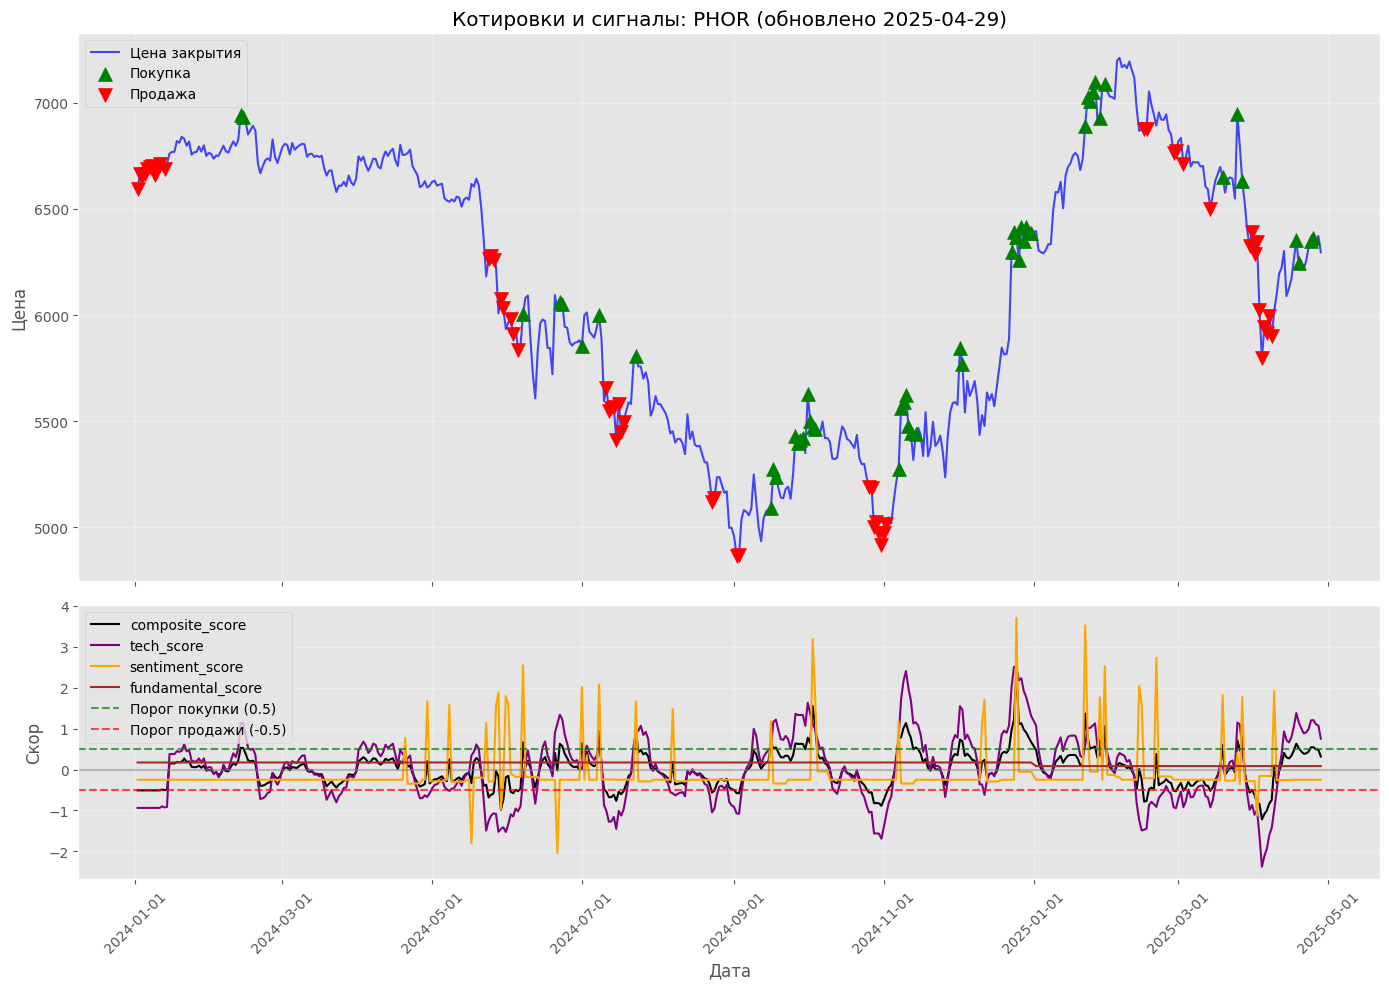

In [ ]:
weights, metrics, report = emulate_bot_portfolio_generation(
    strategy_profile='aggressive',  # 'conservative', 'moderate', 'aggressive'
    allow_short=True,              # Разрешать ли короткие позиции
    custom_params={                # Кастомные параметры (опционально)
        "risk_free_rate": 0.08,
        "min_rf_allocation": 0.2,
        "max_rf_allocation": 0.4,
        'min_assets' : 1,
        'max_assets' : 3
    }
)

for ticker, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    print(f"{ticker}: {weight*100:.2f}%")

print(f"Доходность: {metrics['expected_return']*100:.2f}%")
print(f"Волатильность: {metrics['expected_volatility']*100:.2f}%")
print(f"Шарп: {metrics['sharpe_ratio']:.2f}")